In [1]:
from ietfdata.datatracker import *
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import bigbang.analysis.process as process

### Get draft data

First, get the sample drafts for a range of dates.

In [2]:
window = {"since": "2018-01-01T00:00:00", "until": "2018-01-10T00:00:00"}

In [3]:
dt = DataTracker()


def extract_data(doc):
    data = {}
    ## TODO: Add document UID?
    data["title"] = doc.title
    data["time"] = doc.time
    data["group-acronym"] = dt.group(doc.group).acronym
    data["type"] = doc.type.uri

    affiliations = [doc_author.affiliation for doc_author in dt.document_authors(doc)]

    return [{**data, "affiliation": affiliation} for affiliation in affiliations]


drafts = dt.documents(
    doctype=dt.document_type(DocumentTypeURI("/api/v1/name/doctypename/draft")),
    **window,
)

data = [item for sublist in [extract_data(x) for x in drafts] for item in sublist]

/home/sb/projects/bigbang/bigbang-env/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [4]:
draft_df = pd.DataFrame(data=data)

In [5]:
draft_df.head()

,title,time,group-acronym,type,affiliation
0,EDNS0 OWNER Option,2018-01-04 00:13:03,none,/api/v1/name/doctypename/draft/,Apple Inc.
1,EDNS0 OWNER Option,2018-01-04 00:13:03,none,/api/v1/name/doctypename/draft/,Apple Inc.
2,Distributed Registry Protocol (DRiP),2018-01-04 00:13:23,none,/api/v1/name/doctypename/draft/,Comcast
3,Distributed Registry Protocol (DRiP),2018-01-04 00:13:23,none,/api/v1/name/doctypename/draft/,Comcast
4,PCEP Extensions for Service Function Chaining ...,2018-01-01 00:13:37,none,/api/v1/name/doctypename/draft/,Huawei


Create a table for the group and affiliation links in particular.

In [6]:
link_df = draft_df[["group-acronym", "affiliation", "time"]]
link_df[:5]

,group-acronym,affiliation,time
0,none,Apple Inc.,2018-01-04 00:13:03
1,none,Apple Inc.,2018-01-04 00:13:03
2,none,Comcast,2018-01-04 00:13:23
3,none,Comcast,2018-01-04 00:13:23
4,none,Huawei,2018-01-01 00:13:37


### Entity resolution on the affiliations

Using containment distance, collapse the entities in the `affilation` column and removed suspected duplicates.

In [7]:
all_affiliations = link_df.groupby("affiliation").size()

In [8]:
ents = process.resolve_entities(
    all_affiliations, process.containment_distance, threshold=0.25
)

replacements = {}
for r in [{name: ent for name in ents[ent]} for ent in ents]:
    replacements.update(r)

link_df = link_df.replace(to_replace=replacements)

### Plot the network links between working groups and affiliations

In [9]:
edges = [
    (row[1]["group-acronym"], row[1]["affiliation"])
    for row in link_df[["group-acronym", "affiliation"]].iterrows()
]

In [10]:
G = nx.Graph()

G.add_nodes_from(
    [x[0] for x in link_df[["group-acronym"]].drop_duplicates().values], category=0
)
G.add_nodes_from(all_affiliations.index, category=1)

G.add_edges_from(edges)

In [11]:
## Clean the graph

G.remove_node("none")

for c in list(nx.connected_components(G)):
    if len(c) <= 1:
        for n in c:
            G.remove_node(n)

In [12]:
colors = ["r" if x[1]["category"] else "g" for x in list(G.nodes(data=True))]

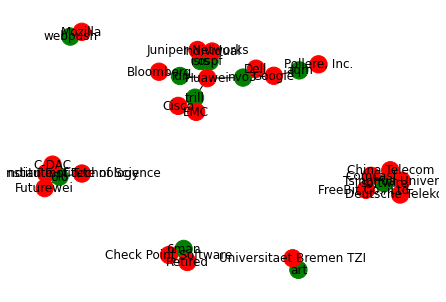

In [13]:
nx.draw(G, node_color=colors, with_labels=True)

In [14]:
nx.write_gexf(G, "group-affiliations.gexf")

### Look at categories of affiliations

In [15]:
import bigbang.datasets.organizations as organizations

cat = organizations.load_data()

In [16]:
replacements = {
    x[1]["name"]: x[1]["category"]
    for x in cat.iterrows()
    if not pd.isna(x[1]["category"])
}

In [17]:
link_cat_df = link_df.replace(to_replace=replacements)

In [18]:
link_cat_df.groupby("affiliation").size().sort_values(ascending=False)[:40]

affiliation
Huawei                                                                                          66
Networking equipment vendor                                                                     46
Telecommunications Provider                                                                     23
                                                                                                14
Advertising company , Content Distribution Network, Software developer, Research Institution     9
China Mobile                                                                                     8
Apple Inc.                                                                                       6
Soongsil University                                                                              6
Individual                                                                                       4
KT                                                                                               

In [19]:
edges = [
    (row[1]["group-acronym"], row[1]["affiliation"])
    for row in link_cat_df[["group-acronym", "affiliation"]].iterrows()
]

affils = link_cat_df.groupby("affiliation").size().index

In [20]:
G = nx.Graph()

G.add_nodes_from(
    [x[0] for x in link_cat_df[["group-acronym"]].drop_duplicates().values], category=0
)
G.add_nodes_from(affils, category=1)

G.add_edges_from(edges)

In [21]:
## Clean the graph

G.remove_node("none")

for c in list(nx.connected_components(G)):
    if len(c) <= 1:
        for n in c:
            G.remove_node(n)

In [22]:
[x[1] for x in list(G.nodes(data=True)) if "category" not in x[1]]

[]

In [23]:
colors = ["r" if x[1]["category"] else "g" for x in list(G.nodes(data=True))]

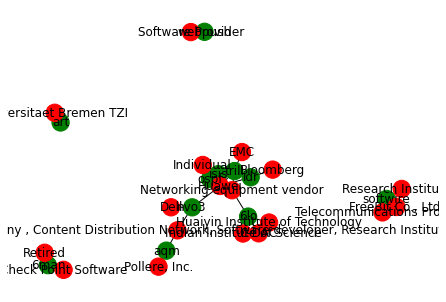

In [24]:
nx.draw(G, node_color=colors, with_labels=True)

In [25]:
nx.write_gexf(G, "group-org-categories.gexf")